In [1]:
#http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html#sphx-glr-auto-examples-text-document-classification-20newsgroups-py
from sklearn.datasets import fetch_20newsgroups
import numpy as np
twenty_train = fetch_20newsgroups(subset='train', shuffle=True)

In [2]:
twenty_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [3]:
print(twenty_train.data[3])

From: jgreen@amber (Joe Green)
Subject: Re: Weitek P9000 ?
Organization: Harris Computer Systems Division
Lines: 14
Distribution: world
NNTP-Posting-Host: amber.ssd.csd.harris.com
X-Newsreader: TIN [version 1.1 PL9]

Robert J.C. Kyanko (rob@rjck.UUCP) wrote:
> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:
> > Anyone know about the Weitek P9000 graphics chip?
> As far as the low-level stuff goes, it looks pretty nice.  It's got this
> quadrilateral fill command that requires just the four points.

Do you have Weitek's address/phone number?  I'd like to get some information
about this chip.

--
Joe Green				Harris Corporation
jgreen@csd.harris.com			Computer Systems Division
"The only thing that really scares me is a person with no sense of humor."
						-- Jonathan Winters



In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#converting a collection of text to a matrix of token counts

#count_vect = CountVectorizer()

#TfidfVectorizer()  - Equivalent to CountVectorizer followed by TfidfTransformer.
#if I use TfidfVectorizer() and then TfidfTransformer() then performance is higher in both cases by more then 1%
tfidf_vect = TfidfVectorizer(stop_words='english')
#term frequency count(word)/total words
X_train_counts = tfidf_vect.fit_transform(twenty_train.data)
X_train_counts.shape
#output [n_samples, n_features]

(11314, 129796)

In [5]:
#TF inverse document frequncy - removing common words like 'the' etc.
# only if we used CountVectorizer() before we use TfidfTranform() now, in case of TfidfVectorizer(9 skip this step)
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(11314, 129796)

In [6]:
# building Naive Bayes Classifier - clf
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=.01).fit(X_train_counts, twenty_train.target)

In [7]:
#show top 10 words for each category

def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: %s" % (category, " ".join(feature_names[top10])))

show_top10(clf, tfidf_vect, twenty_train.target_names)

alt.atheism: people sgi atheism com livesey atheists caltech god edu keith
comp.graphics: polygon subject com university lines files 3d image edu graphics
comp.os.ms-windows.misc: com ax ms drivers driver files dos file edu windows
comp.sys.ibm.pc.hardware: disk pc com controller bus edu card ide drive scsi
comp.sys.mac.hardware: scsi simms monitor centris se quadra drive edu apple mac
comp.windows.x: application x11r5 xterm widget edu com server mit motif window
misc.forsale: lines condition distribution university new shipping offer 00 edu sale
rec.autos: organization subject oil writes article engine edu cars com car
rec.motorcycles: writes ca article motorcycle bikes ride edu dod com bike
rec.sport.baseball: article com runs games players game team year baseball edu
rec.sport.hockey: games season players play nhl edu ca game team hockey
sci.crypt: crypto nsa government escrow keys com chip encryption clipper key
sci.electronics: university ca organization circuit power subject line

In [8]:
#building a pipeline
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
        ('vect', TfidfVectorizer(stop_words='english')),
        #('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB(alpha=.01)),
    ])
text_clf = text_clf.fit(twenty_train.data, twenty_train.target)

In [9]:
#testing performance on test set

twenty_test = fetch_20newsgroups(subset='test', shuffle=True)
predicted = text_clf.predict(twenty_test.data)
np.mean(predicted == twenty_test.target)

0.8336431226765799

In [18]:
from sklearn import metrics

metrics.f1_score(twenty_test.target, predicted, average='macro')

0.8278889894475222

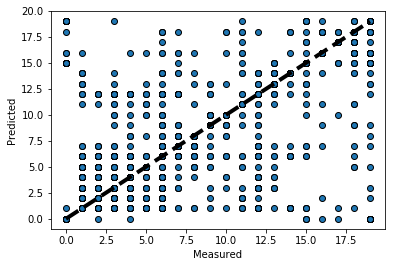

In [20]:
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
X = twenty_train.data
y = twenty_train.target

predicted_cv = cross_val_predict(text_clf, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted_cv, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [24]:
import plotly
plotly.__version__

'2.4.1'

In [30]:
import plotly
import plotly.graph_objs as go

trace1 = go.Scatter(x=y, y=predicted_cv, mode='markers',
                    marker = dict(size=8,
                                  color='rgb(0, 0, 255)',
                                  line=dict(
                                    width=2,
                                    color='rgb(0, 0, 0)'))
                   )
trace2 = go.Scatter(x=[y.min(), y.max()],y=[y.min(), y.max()],
                    line = dict(color=('rgb(0, 0, 0)'),
                                width=5, dash='dash')
                   )
layout = go.Layout(showlegend=False,
                   yaxis=dict(
                    range = [-10,60],
                    zeroline=False,
                    title='Predicted'),
                   xaxis=dict(
                    title='Measured',)
                  )


fig = go.Figure(data = [trace1,trace2], layout = layout)
plotly.offline.plot(fig, filename="predicted_cv.html")



'file://C:\\Users\\kzaytseva\\PycharmProjects\\TextClass\\predicted_cv.html'

In [161]:
#support vector machines
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([
        ('vect', TfidfVectorizer(stop_words='english')),
        #('tfidf', TfidfTransformer()),
        ('clf-svm', SGDClassifier(loss='hinge', alpha=1e-3, n_iter=5, random_state=42)),
    ])
_ = text_clf_svm.fit(twenty_train.data, twenty_train.target)
predicted_svm = text_clf_svm.predict(twenty_test.data)
np.mean(predicted_svm == twenty_test.target)

0.8224907063197026

In [164]:
#tuning for naive bayse clf
from sklearn.model_selection import GridSearchCV

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
#               'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
}

In [165]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(twenty_train.data, twenty_train.target)

In [167]:
gs_clf.best_score_

0.9050733604383949

In [168]:
gs_clf.best_params_

{'clf__alpha': 0.01, 'vect__ngram_range': (1, 1)}

In [1]:
#tuning params for svm with GridSearch
from sklearn.model_selection import GridSearchCV
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
                  #'tfidf__use_idf': (True, False),
                  'clf-svm__alpha': (1e-2, 1e-3),
                 }

In [170]:
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(twenty_train.data, twenty_train.target)

In [171]:
gs_clf_svm.best_score_

0.8954392787696659

gs_clf_svm.best_params_

In [18]:
import nltk

In [19]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [70]:
from nltk.stem.snowball import SnowballStemmer

In [173]:
stemmer = SnowballStemmer("english", ignore_stopwords=True)

In [174]:
class StemmedCountVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
stemmed_count_vec = StemmedCountVectorizer(stop_words='english')
text_mnb_stemmed = Pipeline(
    [
        ('vect', stemmed_count_vec),
        ('tfidf', TfidfTransformer()),
        ('mnb', MultinomialNB(fit_prior=False)),
    ]
)

In [175]:
text_mnb_stemmed = text_mnb_stemmed.fit(twenty_train.data, twenty_train.target)
predicted_mnb_stemmed = text_mnb_stemmed.predict(twenty_test.data)
np.mean(predicted_mnb_stemmed == twenty_test.target)

0.8230217737652682

In [176]:
text_svm_stemmed = Pipeline(
    [
        ('vect', stemmed_count_vec),
        ('tfidf', TfidfTransformer()),
        ('msvm', SGDClassifier(loss='hinge',alpha=1e-3, n_iter=5, random_state=42)),
    ]
)

In [177]:
text_svm_stemmed = text_svm_stemmed.fit(twenty_train.data, twenty_train.target)
predicted_svm_stemmed = text_svm_stemmed.predict(twenty_test.data)
np.mean(predicted_svm_stemmed == twenty_test.target)

0.8305894848645778

In [178]:
from sklearn.metrics import classification_report
#http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

In [179]:
#classification report for stemmed svm
#The support is the number of occurrences of each class in y_true
y_pred = predicted_svm_stemmed
y_true = twenty_test.target
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.76      0.75      0.75       319
          1       0.79      0.74      0.77       389
          2       0.80      0.72      0.76       394
          3       0.70      0.71      0.70       392
          4       0.83      0.82      0.83       385
          5       0.87      0.83      0.85       395
          6       0.87      0.76      0.81       390
          7       0.92      0.90      0.91       396
          8       0.91      0.97      0.94       398
          9       0.87      0.93      0.90       397
         10       0.88      0.99      0.93       399
         11       0.84      0.96      0.90       396
         12       0.82      0.66      0.73       393
         13       0.86      0.88      0.87       396
         14       0.83      0.96      0.89       394
         15       0.77      0.93      0.85       398
         16       0.71      0.94      0.81       364
         17       0.92      0.93      0.93   

In [180]:
#confusion matrix for stemmed svm
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

[[238   0   0   1   0   1   0   0   2   2   0   3   1  11   6  35   3   5
    1  10]
 [  1 288  16   5   8  21   3   3   1   5   5  12   5   4   7   1   1   2
    0   1]
 [  0  15 283  28  14  13   3   1   4   5   4   8   1   3   7   1   0   2
    0   2]
 [  3  10  25 277  15   4  11   2   4   3   0   6  18   1   8   0   1   2
    1   1]
 [  1   4   4  27 316   2   6   3   1   2   2   2   6   1   4   1   2   0
    1   0]
 [  2  29  16   1   3 326   3   0   1   1   0   1   1   3   6   1   1   0
    0   0]
 [  0   2   1  29  12   0 297  12   6   3   3   1   9   4   2   1   4   1
    2   1]
 [  0   1   0   2   1   0   2 358   7   3   2   1  12   3   1   0   2   1
    0   0]
 [  0   0   0   1   0   0   1   4 388   0   1   0   0   3   0   0   0   0
    0   0]
 [  0   0   0   0   1   0   2   0   0 369  23   0   0   0   0   0   1   1
    0   0]
 [  0   0   0   0   0   0   0   0   0   2 395   1   0   0   0   1   0   0
    0   0]
 [  0   0   0   0   1   0   1   0   0   3   0 382   0   2   2   1

In [181]:
with open('cm_stemmed_svm.txt', 'w') as f:
          f.write(np.array2string(confusion_matrix(y_true, y_pred)))

In [182]:
#classification report for stemmed mnb
y_pred = predicted_mnb_stemmed
y_true = twenty_test.target
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.80      0.76      0.78       319
          1       0.79      0.73      0.76       389
          2       0.81      0.67      0.73       394
          3       0.67      0.78      0.72       392
          4       0.84      0.83      0.84       385
          5       0.87      0.81      0.84       395
          6       0.86      0.68      0.76       390
          7       0.89      0.91      0.90       396
          8       0.92      0.97      0.94       398
          9       0.91      0.93      0.92       397
         10       0.90      0.98      0.94       399
         11       0.77      0.96      0.85       396
         12       0.85      0.68      0.75       393
         13       0.90      0.79      0.84       396
         14       0.84      0.94      0.88       394
         15       0.69      0.96      0.80       398
         16       0.68      0.94      0.79       364
         17       0.93      0.96      0.94   

In [183]:
# confusion matrix for stemmed mnb
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

[[242   0   0   1   0   1   0   0   0   1   0   2   0   6   5  46   4   7
    1   3]
 [  1 284  13  14   8  17   5   1   0   4   3  16   7   0  10   3   2   1
    0   0]
 [  0  21 263  49   5  13   2   2   3   4   2  15   1   1   6   4   2   1
    0   0]
 [  1   8  17 307  16   4   8   1   1   1   1   5  12   0   7   1   1   0
    1   0]
 [  1   2   7  15 321   1  10   8   0   2   2   5   5   0   3   1   2   0
    0   0]
 [  1  29  11   8   6 320   1   0   0   1   0   9   1   1   4   1   2   0
    0   0]
 [  1   2   4  39  13   1 264  14  10   6   7   0   9   6   3   2   5   2
    1   1]
 [  0   2   2   2   0   1   3 362   6   3   2   2   2   1   2   0   4   0
    2   0]
 [  0   0   0   1   0   0   1   7 385   0   0   2   1   0   0   0   1   0
    0   0]
 [  0   0   0   0   1   0   1   2   1 370  18   1   0   0   0   0   1   2
    0   0]
 [  0   0   0   0   0   0   0   0   0   3 393   1   0   0   0   2   0   0
    0   0]
 [  0   0   1   0   0   1   1   3   1   1   1 381   1   2   1   0

In [184]:
with open('cm_stemmed_mnb.txt', 'w') as f:
          f.write(np.array2string(confusion_matrix(y_true, y_pred), separator=','))